In [8]:
import pandas as pd
import numpy as np
import os
from glob import glob
from matplotlib import pyplot as plt


Figures!

In [9]:
base_dir = "/Users/nick/Documents/Gillings_work/uncertainty_analysis_data/uncertainty_analysis_2022-12-16_15-55-24-478281"
base_dir = "/Users/nick/Documents/Gillings_work/uncertainty_analysis_data/uncertainty_analysis_2023-03-29_14-16-04-931491"
base_dir = "/Users/nick/Documents/Gillings_work/uncertainty_analysis_data/uncertainty_analysis_2023-03-29_14-16-04-931491_UPDATEDMETHOD_April2023"
output_dir = os.path.join(base_dir, "outputs")
outputs_dirs = [os.path.join(output_dir, f"option_{i}") for i in range(6)]

In [10]:
collection_list_options = []

for opt in range(6):
    outputs = outputs_dirs[opt]
    collection_list = []

    # for each arr, store a 2D array in the list
    # axis = 0 are the groups: menthol, nonmenthol, smoker, ecig/dual, former, never (3, 4, 3+4, 5, 2, 1)
    # axis = 1 are the years 2016, 2021, 2026, 2031, 2051
    for i,f in enumerate(sorted(glob(outputs + "/*.npy"))):
        arr = np.load(f)
        arr = arr[:,:,:,0,:] # age-restrict 18-64
        arr = arr[:16] # get the years we are interested in
        arr = np.sum(arr, axis=(1,2)) # dont care about demographics
        arr = arr[:,:-1] # don't need dead people
        sums = np.sum(arr, axis=1) # total count for each year
        arr = arr / sums[:,np.newaxis] # get proportions
        arr = arr.T # transpose so we have (smoking groups, years) as axes
        arr = np.concatenate([ # want to add the smokers together too
            arr[0:4],
            (arr[2] + arr[3])[np.newaxis, :],
            arr[4][np.newaxis, :],
        ], axis=0)
        arr = arr[[2,3,4,5,1,0]] # re-order the smoking groups
        # add change 2016-2031 column and change from SQ column
        collection_list.append(arr)

    collection_list_options.append(collection_list)

collection_list_options = np.array(collection_list_options)

In [11]:
print(collection_list_options.shape)

(6, 62500, 6, 16)


In [12]:
BRFSS_data = np.array([ 
    [2016, 15.47, 15.23, 15.72],
    [2017, 15.64, 15.36, 15.91],
    [2021, 12.29, 12.05, 12.52],
])

BRFSS_x = BRFSS_data[:,0]
BRFSS_y = BRFSS_data[:,1]
BRFSS_e = BRFSS_data[:,3] - BRFSS_data[:,2]

9.552920744097564


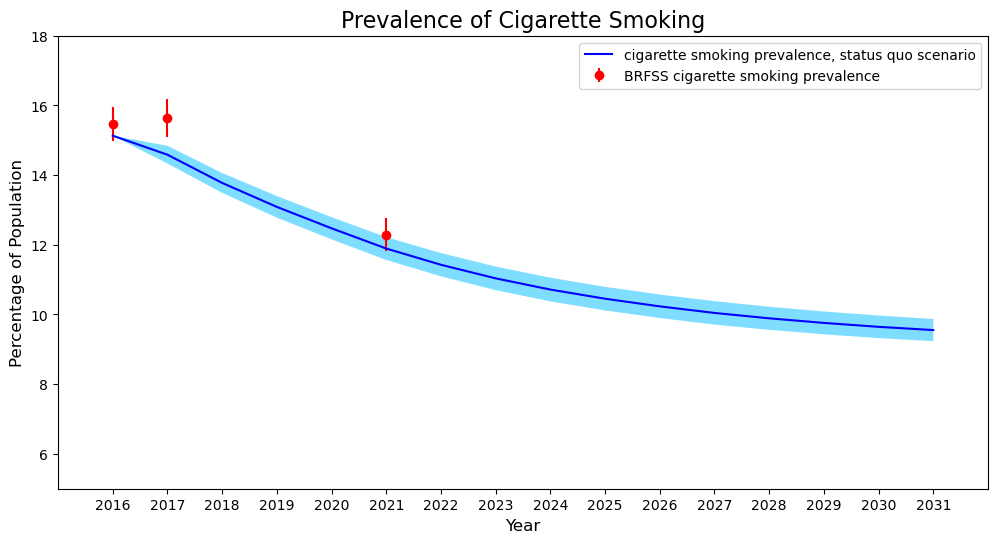

In [13]:
# Cigarette Smokers over time

opt = 0
fig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)

x = np.arange(2016,2032)

to_plot = np.copy(collection_list_options[opt, :, 2, :])
to_plot *= 100

mean = np.mean(to_plot, axis=0)
upper = np.percentile(to_plot, 97.5, axis=0)
lower = np.percentile(to_plot, 2.5, axis=0)
print(mean[-1])

ax.plot(x, mean, "blue")
ax.fill_between(x, lower, upper, facecolor='deepskyblue', alpha=0.5, label='_nolegend_')
ax.errorbar(BRFSS_x, BRFSS_y, yerr=BRFSS_e, fmt='o', color="red")

plt.ylim(5,18)
plt.xlim(x[0]-1, x[-1]+1)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage of Population", fontsize=12)
plt.xticks(x, fontsize=10, horizontalalignment='center')
plt.title(f"Prevalence of Cigarette Smoking", fontsize=16)
plt.legend([ 
    f"cigarette smoking prevalence, status quo scenario",
    f"BRFSS cigarette smoking prevalence",
])

plt.show()





In [14]:
mean_SQ = mean
upper_SQ = upper
lower_SQ = lower

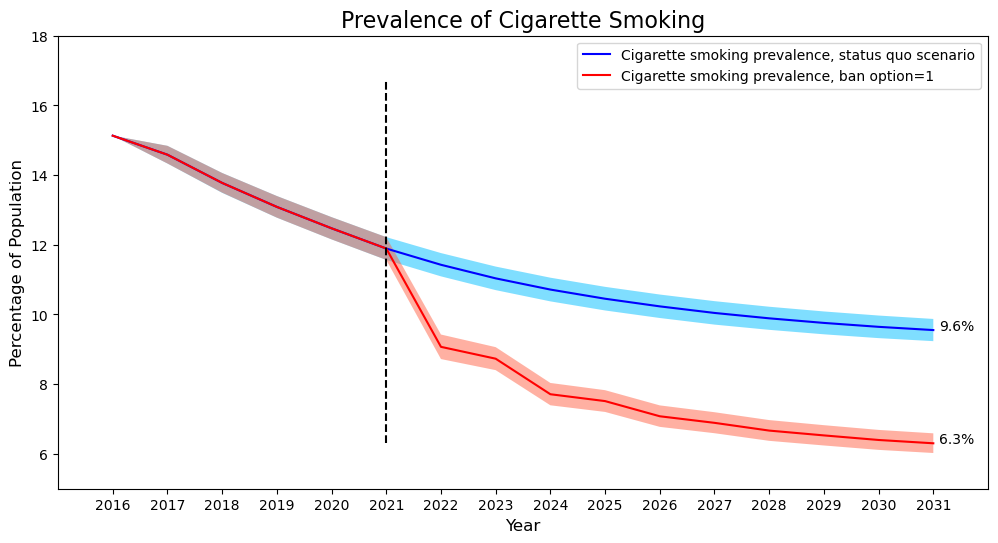

In [15]:

opt = 1
fig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)

x = np.arange(2016,2032)

to_plot = np.copy(collection_list_options[opt, :, 2, :])
to_plot *= 100

mean = np.mean(to_plot, axis=0)
upper = np.percentile(to_plot, 97.5, axis=0)
lower = np.percentile(to_plot, 2.5, axis=0)

ax.plot(x, mean_SQ, "blue")
ax.fill_between(x, lower_SQ, upper_SQ, facecolor='deepskyblue', alpha=0.5, label='_nolegend_')
ax.plot(x, mean, "red")
ax.fill_between(x, lower, upper, facecolor='tomato', alpha=0.5, label='_nolegend_')
ax.axvline(2021, ymin=0.1, ymax=0.9, color='k', linestyle='dashed')

ax.text(2031.1, mean_SQ[-1], f"{np.around(mean_SQ[-1], decimals=1)}%", c='k')
ax.text(2031.1, mean[-1], f"{np.around(mean[-1], decimals=1)}%", c='k')

plt.ylim(5,18)
plt.xlim(x[0]-1, x[-1]+1)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage of Population", fontsize=12)
plt.xticks(x, fontsize=10, horizontalalignment='center')
plt.title(f"Prevalence of Cigarette Smoking", fontsize=16)
plt.legend([ 
    f"Cigarette smoking prevalence, status quo scenario",
    f"Cigarette smoking prevalence, ban option={opt}",
])

plt.show()

Using Status Quo Scenario from uncertainty analysis with 65+ separation

In [16]:
output_dir = "/Users/nick/Documents/Gillings_work/uncertainty_analysis_data_4-25-2023_longleaf_partial/option_0"


collection_list = []

# for each arr, store a 2D array in the list
# axis = 0 will be the iteration
# axis = 1 are the groups: menthol, nonmenthol, smoker, ecig/dual, former, never (3, 4, 3+4, 5, 2, 1)
# axis = 2 will be the years 2016-2031
# axis = 3 will be black
# axis = 4 will be pov
for i,f in enumerate(sorted(glob(output_dir + "/*.npy"))):
    arr = np.load(f)
    # shape at this point is year, black, pov, plus65, smoking_state
    arr = arr[:16] # get the years we are interested in
    arr = arr[:, :, :, 0, :] # remove people 65 and over
    arr = arr[:, :, :, :-1] # don't need dead people
    # sums = np.sum(arr, axis=(1,2,3)) # total count for each year
    # arr = arr / sums[:, np.newaxis, np.newaxis, np.newaxis] # get proportions
    arr = np.transpose(arr, axes=(3,0,1,2)) # transpose so we have (smoking groups, years, black, pov) as axes
    arr = np.concatenate([ # want to add the smokers together too
        arr[0:4],
        (arr[2] + arr[3])[np.newaxis, :,:,:],
        arr[4][np.newaxis, :,:,:],
    ], axis=0)
    arr = arr[[2,3,4,5,1,0]] # re-order the smoking groups

    collection_list.append(arr)

SQ_output_arr = np.array(collection_list)

In [17]:
print(SQ_output_arr.shape)

(62500, 6, 16, 2, 2)


9.552920744097564


Text(0.5, 1.0, 'Prevalence of Cigarette Smoking')

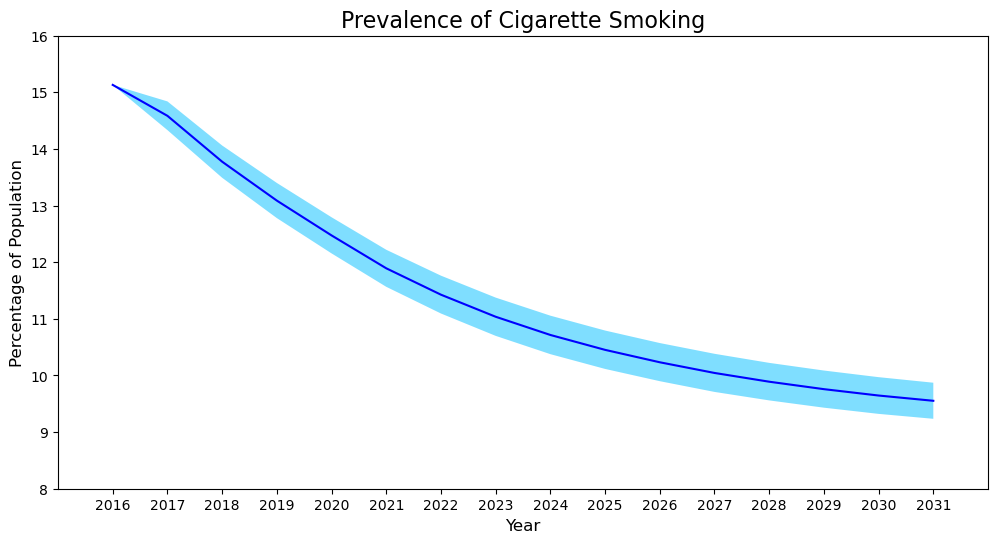

In [18]:

# Cigarette Smokers over time

fig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)

x = np.arange(2016,2032)

# iters, smoking groups, years, black, pov
to_plot = np.copy(SQ_output_arr)
to_plot = to_plot[:,2:,:,:,:]
to_plot = np.sum(to_plot, axis=(3,4))
to_plot /= np.sum(to_plot, axis=1)[:,np.newaxis,:]
to_plot = to_plot[:, 0, :]
to_plot *= 100

mean = np.mean(to_plot, axis=0)
print(mean[-1])
upper = np.percentile(to_plot, 97.5, axis=0)
lower = np.percentile(to_plot, 2.5, axis=0)

ax.plot(x, mean, "blue")
# ax.fill_between(x, lower, upper, facecolor='deepskyblue', alpha=0.5, label='_nolegend_')
ax.fill_between(x, lower, upper, facecolor='deepskyblue', alpha=0.5)

plt.ylim(8,16)
plt.xlim(x[0]-1, x[-1]+1)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage of Population", fontsize=12)
plt.xticks(x, fontsize=10, horizontalalignment='center')
plt.title(f"Prevalence of Cigarette Smoking", fontsize=16)
# plt.legend([ 
#     f"Cigarette smoking prevalence, status quo scenario",
#     f"95% uncertainty interval",
# ])


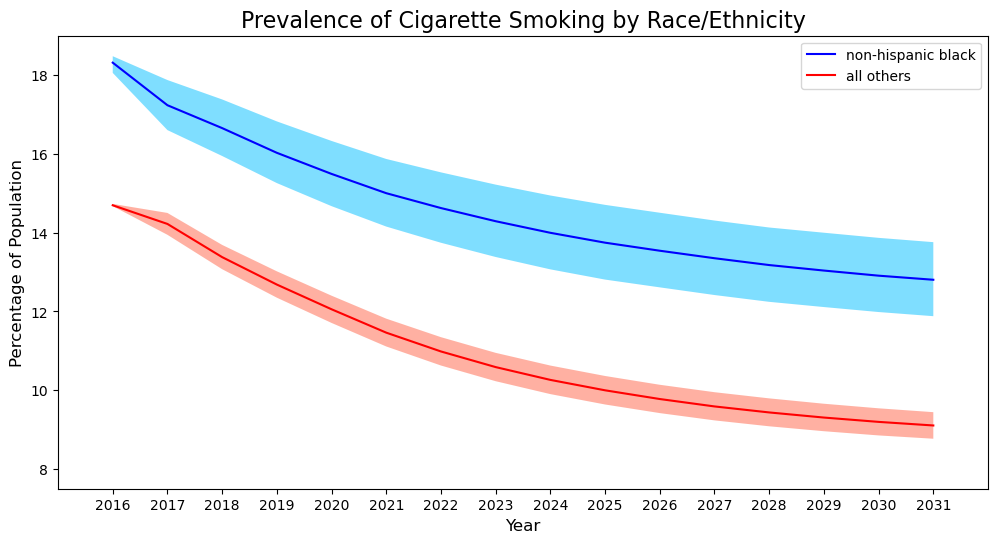

In [19]:

# Cigarette Smokers over time stratified by black

fig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)

x = np.arange(2016,2032)

# iters, smoking groups, years, black, pov
to_plot1 = np.copy(SQ_output_arr)
to_plot1 = to_plot1[:,2:,:,:,:]
to_plot1 = np.sum(to_plot1, axis=4)[:,:,:,0]
to_plot1 /= np.sum(to_plot1, axis=1)[:,np.newaxis,:]
to_plot1 = to_plot1[:, 0, :]
to_plot1 *= 100

to_plot2 = np.copy(SQ_output_arr)
to_plot2 = to_plot2[:,2:,:,:,:]
to_plot2 = np.sum(to_plot2, axis=4)[:,:,:,1]
to_plot2 /= np.sum(to_plot2, axis=1)[:,np.newaxis,:]
to_plot2 = to_plot2[:, 0, :]
to_plot2 *= 100

mean1 = np.mean(to_plot1, axis=0)
upper1 = np.percentile(to_plot1, 97.5, axis=0)
lower1 = np.percentile(to_plot1, 2.5, axis=0)

mean2 = np.mean(to_plot2, axis=0)
upper2 = np.percentile(to_plot2, 97.5, axis=0)
lower2 = np.percentile(to_plot2, 2.5, axis=0)

ax.plot(x, mean2, "blue")
ax.fill_between(x, lower2, upper2, facecolor='deepskyblue', alpha=0.5, label='_nolegend_')

ax.plot(x, mean1, "red")
ax.fill_between(x, lower1, upper1, facecolor='tomato', alpha=0.5, label='_nolegend_')

plt.ylim(7.5,19)
plt.xlim(x[0]-1, x[-1]+1)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage of Population", fontsize=12)
plt.xticks(x, fontsize=10, horizontalalignment='center')
plt.title(f"Prevalence of Cigarette Smoking by Race/Ethnicity", fontsize=16)
plt.legend([ 
    f"non-hispanic black",
    f"all others",
])


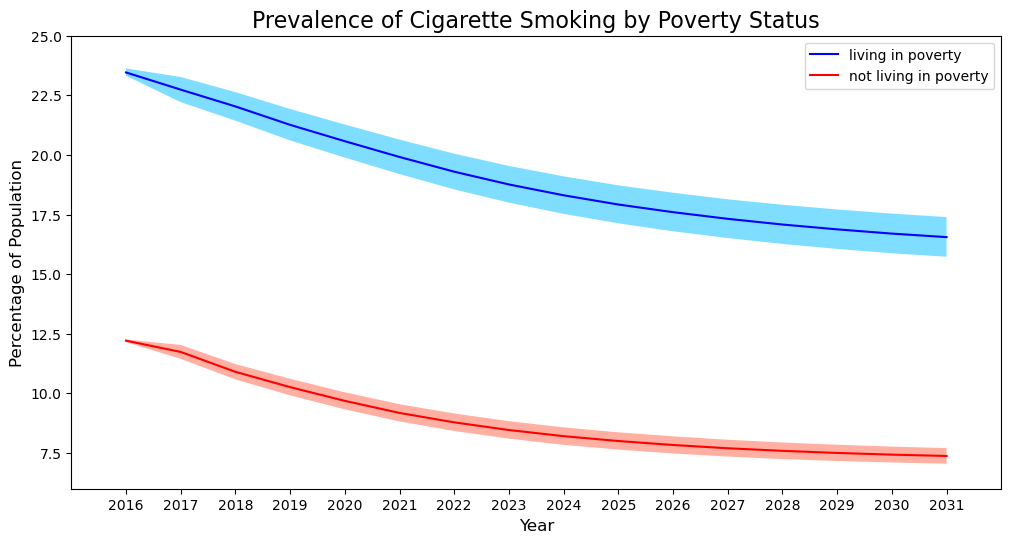

In [20]:

# Cigarette Smokers over time stratified by pov

fig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)

x = np.arange(2016,2032)

# iters, smoking groups, years, black, pov
to_plot1 = np.copy(SQ_output_arr)
to_plot1 = to_plot1[:,2:,:,:,:]
to_plot1 = np.sum(to_plot1, axis=3)[:,:,:,0]
to_plot1 /= np.sum(to_plot1, axis=1)[:,np.newaxis,:]
to_plot1 = to_plot1[:, 0, :]
to_plot1 *= 100

to_plot2 = np.copy(SQ_output_arr)
to_plot2 = to_plot2[:,2:,:,:,:]
to_plot2 = np.sum(to_plot2, axis=3)[:,:,:,1]
to_plot2 /= np.sum(to_plot2, axis=1)[:,np.newaxis,:]
to_plot2 = to_plot2[:, 0, :]
to_plot2 *= 100

mean1 = np.mean(to_plot1, axis=0)
upper1 = np.percentile(to_plot1, 97.5, axis=0)
lower1 = np.percentile(to_plot1, 2.5, axis=0)

mean2 = np.mean(to_plot2, axis=0)
upper2 = np.percentile(to_plot2, 97.5, axis=0)
lower2 = np.percentile(to_plot2, 2.5, axis=0)

ax.plot(x, mean2, "blue")
ax.fill_between(x, lower2, upper2, facecolor='deepskyblue', alpha=0.5, label='_nolegend_')

ax.plot(x, mean1, "red")
ax.fill_between(x, lower1, upper1, facecolor='tomato', alpha=0.5, label='_nolegend_')

plt.ylim(6,25)
plt.xlim(x[0]-1, x[-1]+1)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage of Population", fontsize=12)
plt.xticks(x, fontsize=10, horizontalalignment='center')
plt.title(f"Prevalence of Cigarette Smoking by Poverty Status", fontsize=16)
plt.legend([ 
    f"living in poverty",
    f"not living in poverty",
])

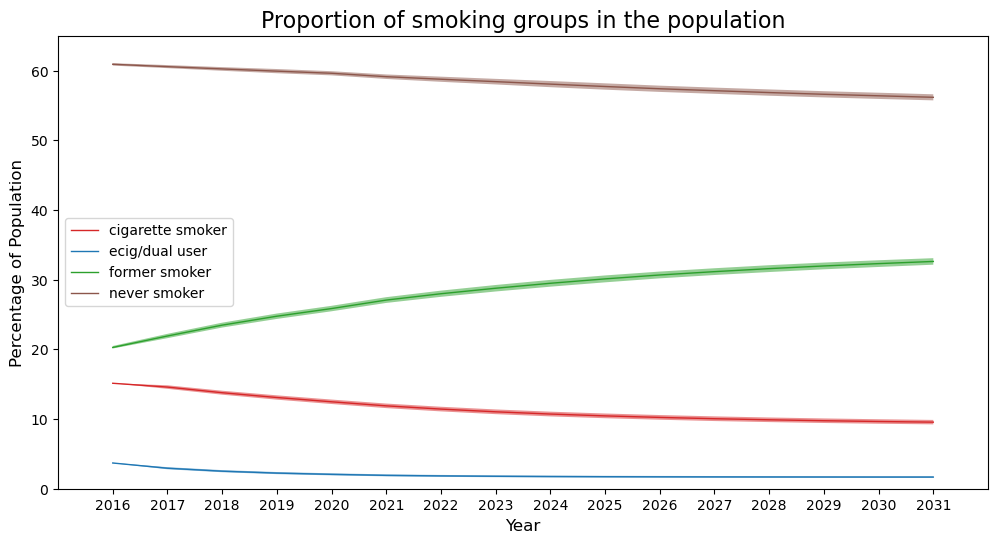

In [21]:

# Cigarette Smokers over time
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:brown']

fig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)

x = np.arange(2016,2032)

# iters, smoking groups, years, black, pov
to_plot = np.copy(SQ_output_arr)
to_plot = to_plot[:,2:,:,:,:]
to_plot = np.sum(to_plot, axis=(3,4))
to_plot /= np.sum(to_plot, axis=1)[:,np.newaxis,:]
to_plot *= 100

mean = np.mean(to_plot, axis=0)
upper = np.percentile(to_plot, 97.5, axis=0)
lower = np.percentile(to_plot, 2.5, axis=0)

ax.plot(
    x, mean[0,:], mycolors[0],
    x, mean[1,:], mycolors[1],
    x, mean[2,:], mycolors[2],
    x, mean[3,:], mycolors[3], linewidth=1
)

ax.fill_between(x, lower[0,:], upper[0,:], facecolor=mycolors[0], alpha=0.5, label='_nolegend_')
ax.fill_between(x, lower[1,:], upper[1,:], facecolor=mycolors[1], alpha=0.5, label='_nolegend_')
ax.fill_between(x, lower[2,:], upper[2,:], facecolor=mycolors[2], alpha=0.5, label='_nolegend_')
ax.fill_between(x, lower[3,:], upper[3,:], facecolor=mycolors[3], alpha=0.5, label='_nolegend_')

plt.ylim(0,65)
plt.xlim(x[0]-1, x[-1]+1)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage of Population", fontsize=12)
plt.xticks(x, fontsize=10, horizontalalignment='center')
plt.title(f"Proportion of smoking groups in the population", fontsize=16)
plt.legend([ 
    f"cigarette smoker",
    f"ecig/dual user",
    f"former smoker",
    f"never smoker",
])


In [22]:
BRFSS_data = np.array([ 
    [2016, 15.47, 15.23, 15.72],
    [2017, 15.64, 15.36, 15.91],
    [2021, 12.29, 12.05, 12.52],
])

BRFSS_x = BRFSS_data[:,0]
BRFSS_y = BRFSS_data[:,1]
BRFSS_e = BRFSS_data[:,3] - BRFSS_data[:,2]

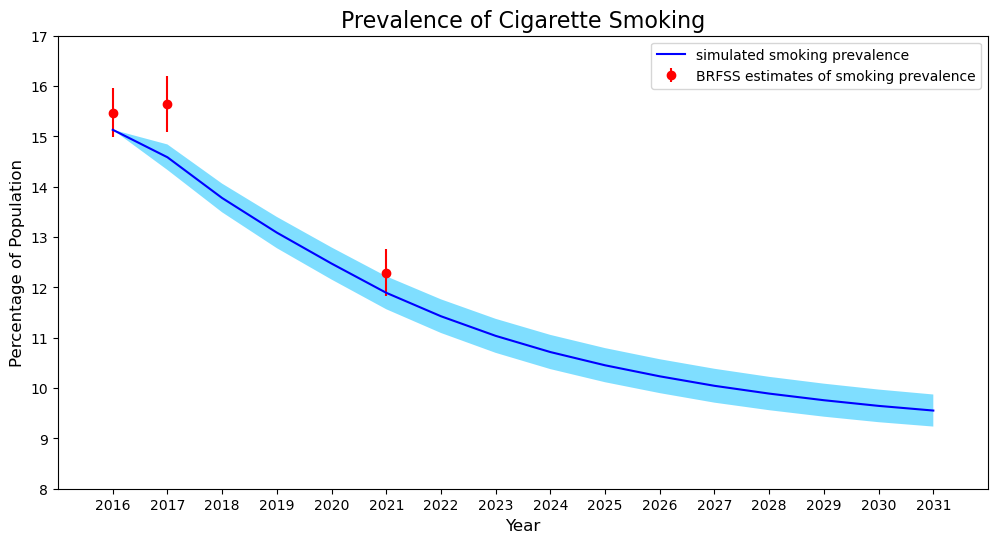

In [23]:

# Cigarette Smokers over time

fig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)

x = np.arange(2016,2032)

# iters, smoking groups, years, black, pov
to_plot = np.copy(SQ_output_arr)
to_plot = to_plot[:,2:,:,:,:]
to_plot = np.sum(to_plot, axis=(3,4))
to_plot /= np.sum(to_plot, axis=1)[:,np.newaxis,:]
to_plot = to_plot[:, 0, :]
to_plot *= 100

mean = np.mean(to_plot, axis=0)
upper = np.percentile(to_plot, 97.5, axis=0)
lower = np.percentile(to_plot, 2.5, axis=0)

ax.plot(x, mean, "blue")
ax.fill_between(x, lower, upper, facecolor='deepskyblue', alpha=0.5, label="_nolegend_")
ax.errorbar(BRFSS_x, BRFSS_y, yerr=BRFSS_e, fmt='o', color="red")

plt.ylim(8,17)
plt.xlim(x[0]-1, x[-1]+1)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage of Population", fontsize=12)
plt.xticks(x, fontsize=10, horizontalalignment='center')
plt.title(f"Prevalence of Cigarette Smoking", fontsize=16)
plt.legend([ 
    f"simulated smoking prevalence",
    f"BRFSS estimates of smoking prevalence",
])


In [24]:
BRFSS_data = np.array([ 
    [2016, 17.43, 16.64, 18.21],
    [2017, 17.84, 17.00, 18.68],
    [2021, 14.36, 13.60, 15.11],
])

BRFSS_x = BRFSS_data[:,0]
BRFSS_y = BRFSS_data[:,1]
BRFSS_e = BRFSS_data[:,3] - BRFSS_data[:,2]

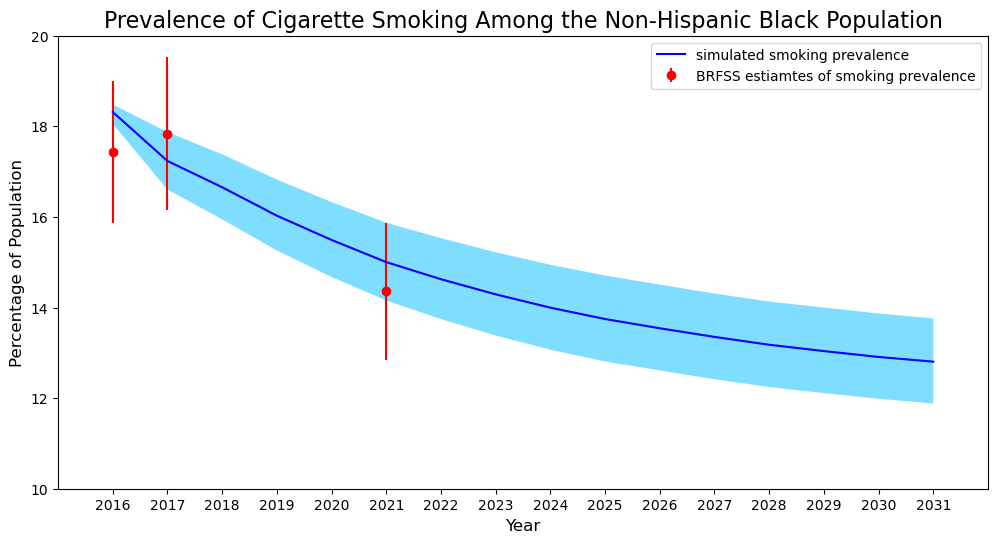

In [25]:

# Cigarette Smokers over time

fig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)

x = np.arange(2016,2032)

# iters, smoking groups, years, black, pov
to_plot = np.copy(SQ_output_arr)
to_plot = to_plot[:,2:,:,:,:]
to_plot = np.sum(to_plot, axis=4)[:,:,:,1]
to_plot /= np.sum(to_plot, axis=1)[:,np.newaxis,:]
to_plot = to_plot[:, 0, :]
to_plot *= 100

mean = np.mean(to_plot, axis=0)
upper = np.percentile(to_plot, 97.5, axis=0)
lower = np.percentile(to_plot, 2.5, axis=0)

ax.plot(x, mean, "blue")
ax.fill_between(x, lower, upper, facecolor='deepskyblue', alpha=0.5, label="_nolegend_")
ax.errorbar(BRFSS_x, BRFSS_y, yerr=BRFSS_e, fmt='o', color="red")

plt.ylim(10,20)
plt.xlim(x[0]-1, x[-1]+1)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage of Population", fontsize=12)
plt.xticks(x, fontsize=10, horizontalalignment='center')
plt.title(f"Prevalence of Cigarette Smoking Among the Non-Hispanic Black Population", fontsize=16)
plt.legend([ 
    f"simulated smoking prevalence",
    f"BRFSS estiamtes of smoking prevalence",
])


In [26]:
# NSDUH Data (2016-2020)

NSDUH_all = np.array([39.17, 40.11, 40.98, 42.04, 43.51])
NSDUH_black = np.array([87.36, 82.75, 86.39, 85.96, 80.42])
NSDUH_pov = np.array([45.39, 47.01, 47.54, 52.64, 52.83])

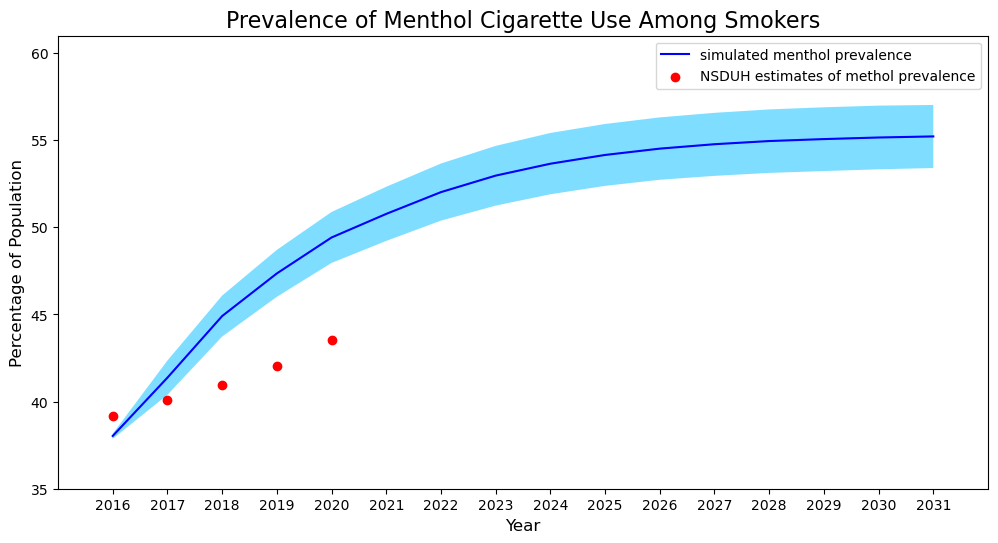

In [27]:
# Menthol users among all smokers

fig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)

x = np.arange(2016,2032)

# iters, smoking groups, years, black, pov
to_plot = np.copy(SQ_output_arr)
to_plot = to_plot[:,:2,:,:,:]
to_plot = np.sum(to_plot, axis=(3,4))
to_plot /= np.sum(to_plot, axis=1)[:,np.newaxis,:]
to_plot = to_plot[:, 0, :]
to_plot *= 100

mean = np.mean(to_plot, axis=0)
upper = np.percentile(to_plot, 97.5, axis=0)
lower = np.percentile(to_plot, 2.5, axis=0)

ax.plot(x, mean, "blue")
ax.fill_between(x, lower, upper, facecolor='deepskyblue', alpha=0.5, label="_nolegend_")
ax.scatter(np.arange(2016,2021), NSDUH_all, c='red')

plt.ylim(35,61)
plt.xlim(x[0]-1, x[-1]+1)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage of Population", fontsize=12)
plt.xticks(x, fontsize=10, horizontalalignment='center')
plt.title(f"Prevalence of Menthol Cigarette Use Among Smokers", fontsize=16)
plt.legend([ 
    f"simulated menthol prevalence",
    f"NSDUH estimates of methol prevalence",
])

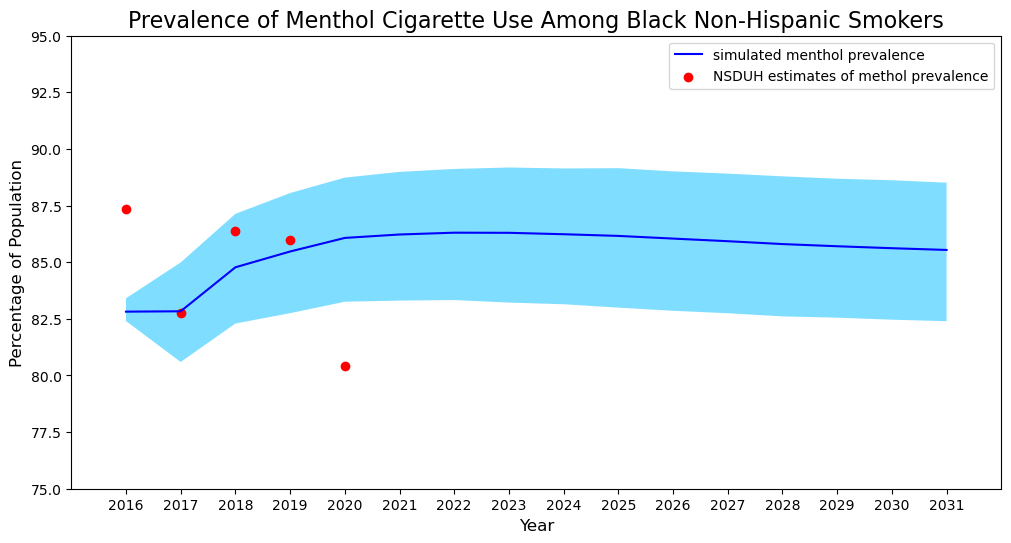

In [28]:

# Menthol users among black smokers

fig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)

x = np.arange(2016,2032)

# iters, smoking groups, years, black, pov
to_plot = np.copy(SQ_output_arr)
to_plot = to_plot[:,:2,:,:,:]
to_plot = np.sum(to_plot, axis=4)[:,:,:,1]
to_plot /= np.sum(to_plot, axis=1)[:,np.newaxis,:]
to_plot = to_plot[:, 0, :]
to_plot *= 100

mean = np.mean(to_plot, axis=0)
upper = np.percentile(to_plot, 97.5, axis=0)
lower = np.percentile(to_plot, 2.5, axis=0)

ax.plot(x, mean, "blue")
ax.fill_between(x, lower, upper, facecolor='deepskyblue', alpha=0.5, label="_nolegend_")
ax.scatter(np.arange(2016,2021), NSDUH_black, c='red')

plt.ylim(75, 95)
plt.xlim(x[0]-1, x[-1]+1)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage of Population", fontsize=12)
plt.xticks(x, fontsize=10, horizontalalignment='center')
plt.title(f"Prevalence of Menthol Cigarette Use Among Black Non-Hispanic Smokers", fontsize=16)
plt.legend([ 
    f"simulated menthol prevalence",
    f"NSDUH estimates of methol prevalence",
])

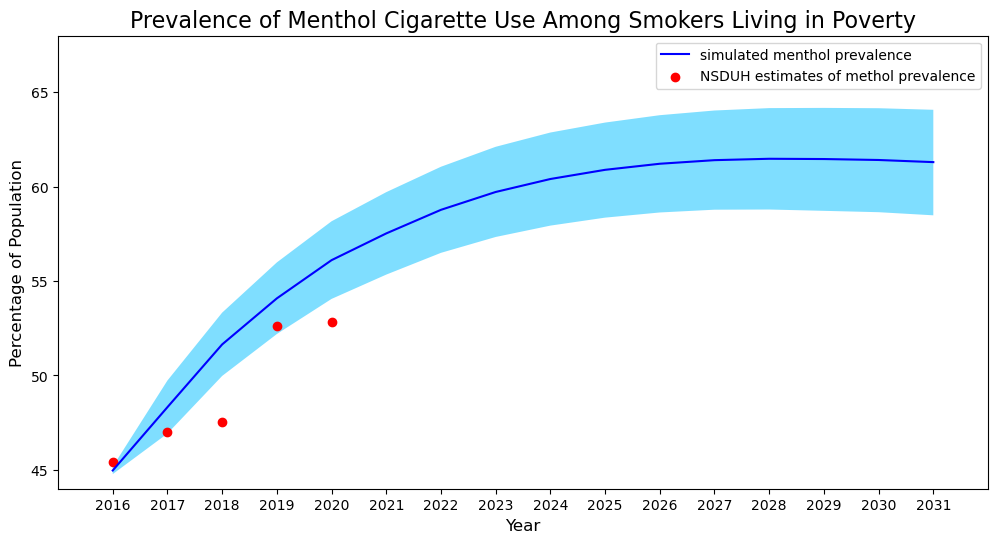

In [29]:

# Menthol users among pov smokers

fig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)

x = np.arange(2016,2032)

# iters, smoking groups, years, black, pov
to_plot = np.copy(SQ_output_arr)
to_plot = to_plot[:,:2,:,:,:]
to_plot = np.sum(to_plot, axis=3)[:,:,:,1]
to_plot /= np.sum(to_plot, axis=1)[:,np.newaxis,:]
to_plot = to_plot[:, 0, :]
to_plot *= 100

mean = np.mean(to_plot, axis=0)
upper = np.percentile(to_plot, 97.5, axis=0)
lower = np.percentile(to_plot, 2.5, axis=0)

ax.plot(x, mean, "blue")
ax.fill_between(x, lower, upper, facecolor='deepskyblue', alpha=0.5, label="_nolegend_")
ax.scatter(np.arange(2016,2021), NSDUH_pov, c='red')

plt.ylim(44, 68)
plt.xlim(x[0]-1, x[-1]+1)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage of Population", fontsize=12)
plt.xticks(x, fontsize=10, horizontalalignment='center')
plt.title(f"Prevalence of Menthol Cigarette Use Among Smokers Living in Poverty", fontsize=16)
plt.legend([ 
    f"simulated menthol prevalence",
    f"NSDUH estimates of methol prevalence",
])

In [30]:
# Looking at old people just for fun

output_dir = "/Users/nick/Documents/Gillings_work/uncertainty_analysis_data_4-25-2023_longleaf_partial/option_0"

collection_list = []

# for each arr, store a 2D array in the list
# axis = 0 will be the iteration
# axis = 1 are the groups: menthol, nonmenthol, smoker, ecig/dual, former, never (3, 4, 3+4, 5, 2, 1)
# axis = 2 will be the years 2016-2031
# axis = 3 will be black
# axis = 4 will be pov
for i,f in enumerate(sorted(glob(output_dir + "/*.npy"))):
    arr = np.load(f)
    # shape at this point is year, black, pov, plus65, smoking_state
    arr = arr[1:16] # get the years we are interested in
    arr = arr[:, :, :, 1, :] # remove people 65 and over
    arr = arr[:, :, :, :-1] # don't need dead people
    # sums = np.sum(arr, axis=(1,2,3)) # total count for each year
    # arr = arr / sums[:, np.newaxis, np.newaxis, np.newaxis] # get proportions
    arr = np.transpose(arr, axes=(3,0,1,2)) # transpose so we have (smoking groups, years, black, pov) as axes
    arr = np.concatenate([ # want to add the smokers together too
        arr[0:4],
        (arr[2] + arr[3])[np.newaxis, :,:,:],
        arr[4][np.newaxis, :,:,:],
    ], axis=0)
    arr = arr[[2,3,4,5,1,0]] # re-order the smoking groups

    collection_list.append(arr)

SQ_output_arr = np.array(collection_list)

7.234478883532456


Text(0.5, 1.0, 'Prevalence of Cigarette Smoking Among 65+ Year-Olds')

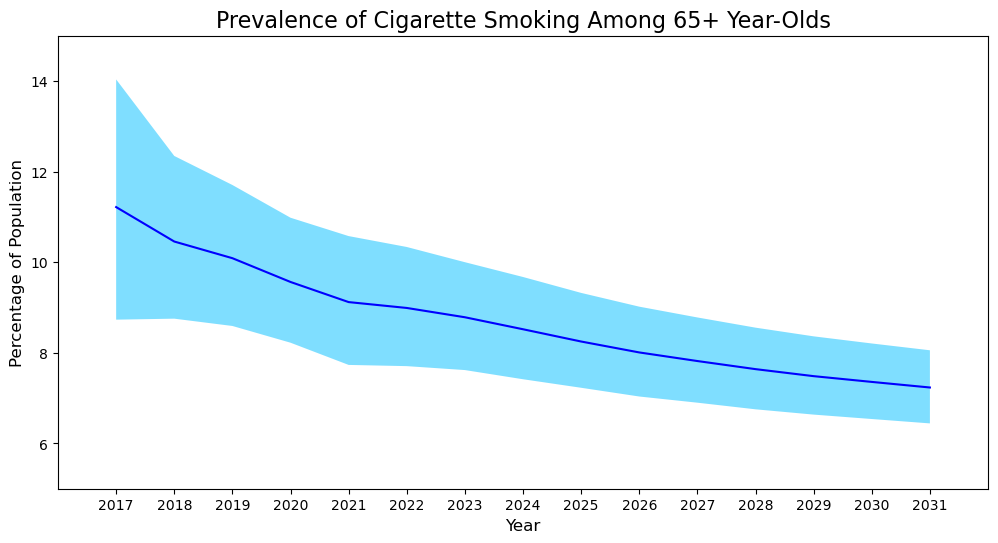

In [31]:

# Cigarette Smokers over time

fig, ax = plt.subplots(1,1,figsize=(12,6), dpi=100)

x = np.arange(2017,2032)

# iters, smoking groups, years, black, pov
to_plot = np.copy(SQ_output_arr)
to_plot = to_plot[:,2:,:,:,:]
to_plot = np.sum(to_plot, axis=(3,4))
to_plot /= np.sum(to_plot, axis=1)[:,np.newaxis,:]
to_plot = to_plot[:, 0, :]
to_plot *= 100

mean = np.mean(to_plot, axis=0)
print(mean[-1])
upper = np.percentile(to_plot, 97.5, axis=0)
lower = np.percentile(to_plot, 2.5, axis=0)

ax.plot(x, mean, "blue")
# ax.fill_between(x, lower, upper, facecolor='deepskyblue', alpha=0.5, label='_nolegend_')
ax.fill_between(x, lower, upper, facecolor='deepskyblue', alpha=0.5)

plt.ylim(5,15)
plt.xlim(x[0]-1, x[-1]+1)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Percentage of Population", fontsize=12)
plt.xticks(x, fontsize=10, horizontalalignment='center')
plt.title(f"Prevalence of Cigarette Smoking Among 65+ Year-Olds", fontsize=16)
# plt.legend([ 
#     f"Cigarette smoking prevalence, status quo scenario",
#     f"95% uncertainty interval",
# ])
